CARICO LE LIBRERIE DA UTILIZZARE

In [1]:
from statsmodels.tsa.stattools import adfuller, kpss
import yfinance as yf ## for finance
import pandas as pd ## dataframes
import datetime as dt
import numpy as np ## linear algebra
np.random.seed(11) ## for reproducibility
import matplotlib.pyplot as plt
from scipy import stats ## main python statistical package
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

CARICO I DATASETS

In [20]:

intel_0 = pd.read_csv('RACE.csv')
tsmc_0 = pd.read_csv('TSMC34.SA.csv')
stm_0 = pd.read_csv('STM.csv')
fujhy_0 = pd.read_csv('FUJHY.csv')
cah_0 = pd.read_csv('SeP500.csv')
covid_0 = pd.read_csv('owid-covid-data.csv')


RIARRANGIO I DATI DEL covid IN MODO TALE DA AVERE LA SOMMA DEI CONTAGI GLOBALI

In [4]:
intel_0 = intel_0.rename(columns={'Adj Close':'intel'})
tsmc_0 = tsmc_0.rename(columns={'Adj Close':'tsmc'})
stm_0 = stm_0.rename(columns={'Adj Close':'stm'})
fujhy_0 = fujhy_0.rename(columns={'Adj Close':'fujhy'})
cah_0 = cah_0.rename(columns={'Adj Close':'cah'})
intel=intel_0['intel']
tsmc = tsmc_0['tsmc']
stm = stm_0['stm']
fujhy = fujhy_0['fujhy']
cah = cah_0['cah']

covid_0['date'] = pd.to_datetime(covid_0['date'])
appoggio = covid_0.groupby('date')['new_cases'].sum().reset_index()
appoggio1=appoggio.dropna()
appoggio1=appoggio1.rename(columns={'new_cases':'covid'})
covid= appoggio1['covid'].iloc[373:]

(<matplotlib.legend.Legend at 0x7f2687392500>,
 <matplotlib.legend.Legend at 0x7f2687361570>)

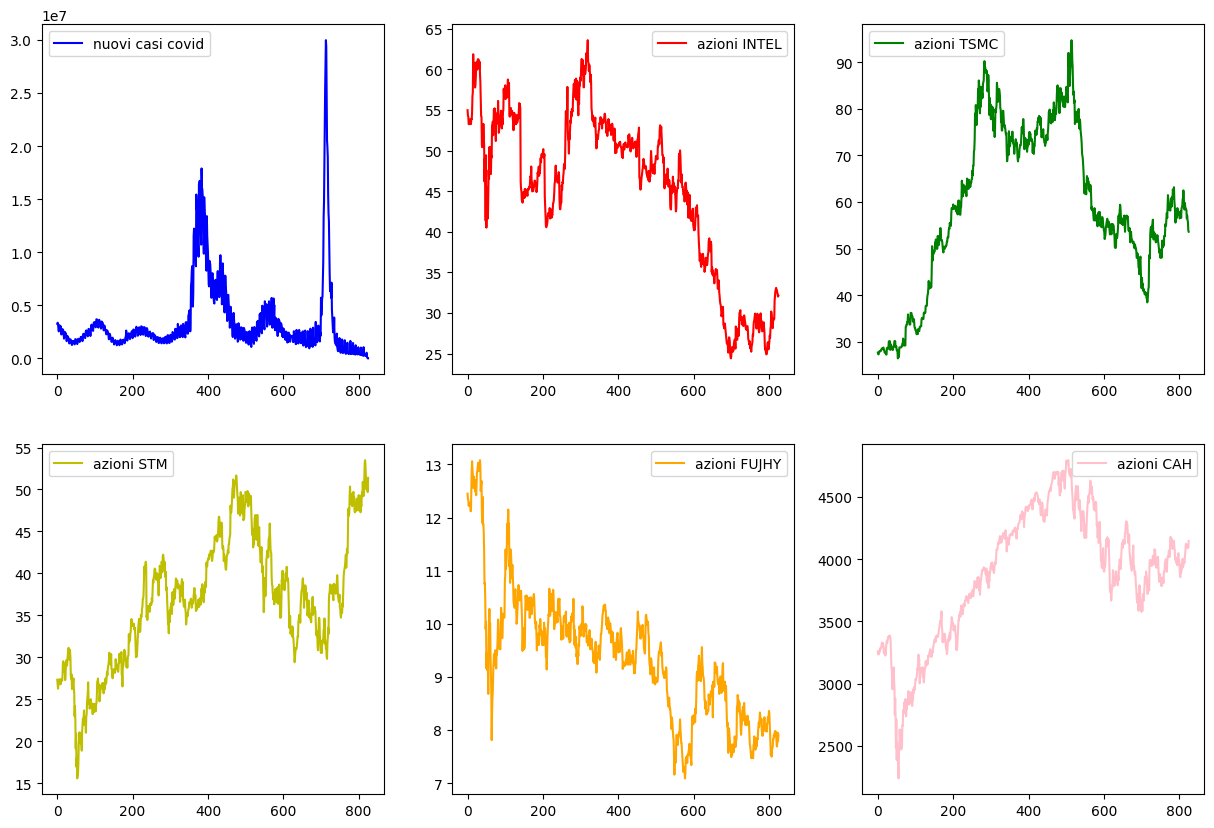

In [5]:
fig, ax = plt.subplots(nrows=2,ncols=3,figsize=(15,10))
anni=list(range(0,826))
date_range = pd.date_range(start='2020-1-5', end='2023-04-14', freq='M')
ax[0,0].plot(anni,covid,color='b',label='nuovi casi covid')
ax[0,1].plot(anni,intel,color='r',label='azioni INTEL')
ax[0,2].plot(anni,tsmc,color='g',label='azioni TSMC')
ax[1,0].plot(anni,stm,color='y',label='azioni STM')
ax[1,1].plot(anni,fujhy,color='orange',label='azioni FUJHY')
ax[1,2].plot(anni,cah,color='pink',label='azioni CAH')
ax[0,0].legend(),ax[0,1].legend(),ax[0,2].legend(),ax[1,0].legend(),ax[1,1].legend(),ax[1,2].legend()

DEVO DIFFERENZIARE TUTTE LE MIE GRANDEZZE

importo u po' di fuznioni

In [6]:
### 1. Check whether the two processes are stationary
### Two common tests are 
### A. Augmented Dickey-Fuller (ADF) Test
### B. Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test


### ADF test is conducted with the following assumptions:
### Null Hypothesis (HO): Series is non-stationary, or series has a unit root.
### Alternate Hypothesis(HA): Series is stationary, or series has no unit root.
### If the null hypothesis is failed to be rejected, this test may provide evidence that the series is non-stationary.

def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dfoutput[1] > 0.05:
        print("\n*** Time series is not stationary ***\n")
    else:
        print("\n*** Time series is stationary ***\n")

### The KPSS test is conducted with the following assumptions.
### Null Hypothesis (HO): Series is trend stationary or series has no unit root.
### Alternate Hypothesis(HA): Series is non-stationary, or series has a unit root.
### Note: The hypothesis is reversed in the KPSS test compared to ADF Test.
    
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','#Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)
    if kpss_output[1] < 0.05:
        print("\n*** Time series is not stationary ***\n")
    else:
        print("\n*** Time series is stationary ***\n")
        
import warnings
warnings.filterwarnings("ignore")

def diff(X_t, dt):
    N = len(X_t)
    diff_X_t = []
    for i in range(N):
        if i==0:
            diff = (X_t[i+1]-X_t[i])/dt
            diff_X_t.append(diff)
        
        elif i==N-1:
            diff = (X_t[i]-X_t[i-1])/dt
            diff_X_t.append(diff)
            
        else:
            diff_fw = (X_t[i+1]-X_t[i])/dt
            diff_bw = (X_t[i]-X_t[i-1])/dt
            diff = 0.5*(diff_fw+diff_bw)
            diff_X_t.append(diff)
    return diff_X_t

## 3. perform cross correlation analysis
def CrossCorrelationAnalysis(X, Y, maxlag, dt=1):
    """
    Perform the lagged-cross-correlation analysis between two time series X(t) and Y(t).
    X, Y are two 1-d numpy arrays.
    dt is the time step of the time series (default 1 a.u.) - it could be specified w.r.t a given unit
    """
    
    ### Make sure the two time series are stationary
    ### Performing for example the Augmented Dickey-Fuller Test
    from statsmodels.tsa.stattools import adfuller
    result_X, result_Y = adfuller(X), adfuller(Y)
    if (result_X[1] > 0.05 or result_Y[1]>0.05):
        print("Time Series are not stationary")
        return
    else:
        ## we consider X(t+lag), Y(t)
        ## so that for lag<0 X preceeds Y and vice-versa.
        dim = len(X)
        lags = np.arange(-maxlag, maxlag+1, 1)
        lagged_cross_corr = []
        for lag in lags:
            XY = [(X[t+lag], Y[t]) for t in range(dim-np.abs(lag))]
            X_lagged = [el[0] for el in XY]
            Y_lagged = [el[1] for el in XY]
            lagged_cross_corr.append(stats.pearsonr(X_lagged, Y_lagged)[0])
            
        plt.figure(figsize=(3, 3), dpi=180)
        lags_min = [l for l in lags if l<=0]
        lags_maj = [l for l in lags if l>=0]
        lcc_min = [lagged_cross_corr[i] for i in range(len(lags)) if lags[i]<=0]
        lcc_maj = [lagged_cross_corr[i] for i in range(len(lags)) if lags[i]>=0]
        plt.plot(lags_min, lcc_min, lw=3, color='b')
        plt.plot(lags_maj, lcc_maj, lw=3, color='r')
        plt.vlines(0, -1, 1, lw=2, ls='--', color='k')
        plt.xlabel('time lags'), plt.ylabel('lagged-cross-correlation')
        plt.text(-50, 0.8, 'X preceeds Y', color='b')
        plt.text(5, 0.8, 'Y preceeds X', color='r')
        corr=lcc_min+lcc_maj
        lag = np.argmax(corr) - 50
        print("Lo sfasamento tra le due serie è di", lag, "unità di tempo.")
        plt.show()

differenzio tsmc e stm

------------------------
TEST STAZIONARIETA' STM
------------------------
Results of Dickey-Fuller Test:
Test Statistic                -7.677555e+00
p-value                        1.534397e-11
#Lags Used                     1.900000e+01
Number of Observations Used    8.060000e+02
Critical Value (1%)           -3.438489e+00
Critical Value (5%)           -2.865133e+00
Critical Value (10%)          -2.568683e+00
dtype: float64

*** Time series is stationary ***

Results of KPSS Test:
Test Statistic           0.068047
p-value                  0.100000
#Lags Used               7.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64

*** Time series is stationary ***

------------------------
TEST STAZIONARIETA' TSMC
------------------------
Results of Dickey-Fuller Test:
Test Statistic                -7.486502e+00
p-value                        4.624072e-11
#Lags Used                     

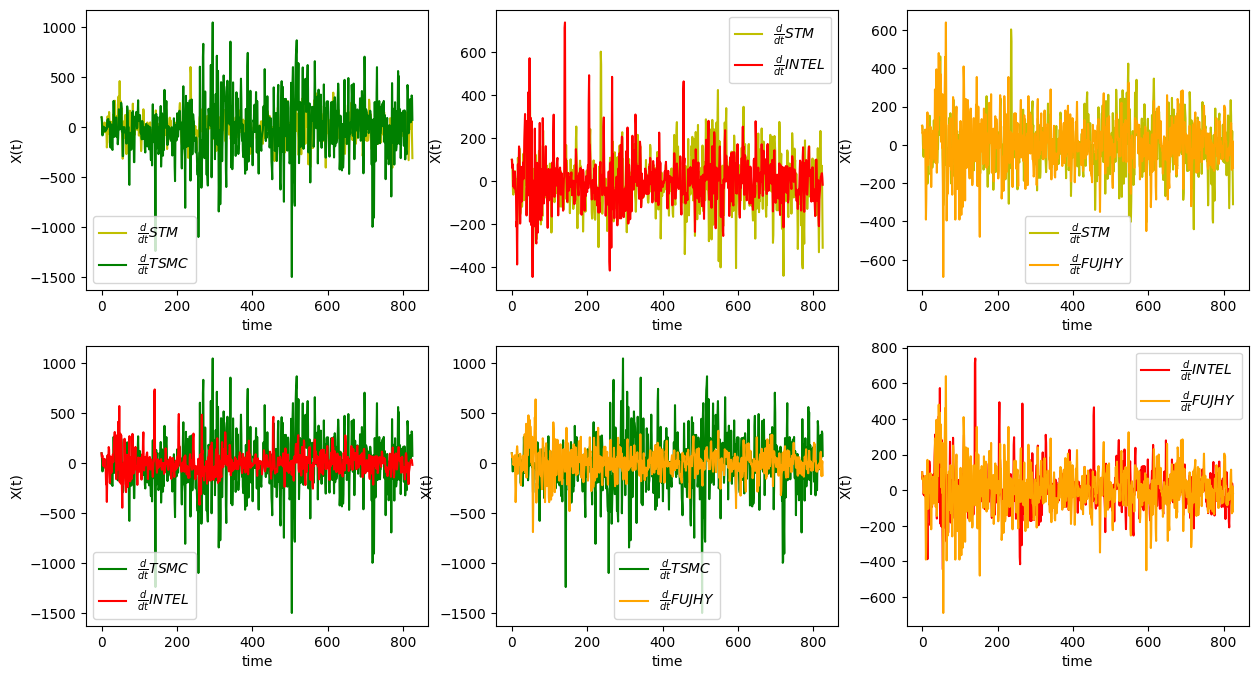

In [7]:
Delta_t=1
stm_diff = diff(stm, Delta_t)
tsmc_diff = diff(tsmc, Delta_t)
intel_diff = diff(intel,Delta_t)
fujhy_diff = diff(fujhy,Delta_t)
cah_diff = diff(cah,Delta_t)
#covid_diff = diff(covid.dropna(),Delta_t)
print('------------------------')
print('TEST STAZIONARIETA\' STM')
print('------------------------')
adf_test(stm_diff)
kpss_test(stm_diff)
print('------------------------')
print('TEST STAZIONARIETA\' TSMC')
print('------------------------')
adf_test(tsmc_diff)
kpss_test(tsmc_diff)
print('------------------------')
print('TEST STAZIONARIETA\' INTEL')
print('------------------------')
adf_test(intel_diff)
kpss_test(intel_diff)
print('------------------------')
print('TEST STAZIONARIETA\' CAH')
print('------------------------')
adf_test(cah_diff)
kpss_test(cah_diff)
print('TEST STAZIONARIETA\' FUJHY')
print('------------------------')
adf_test(fujhy_diff)
kpss_test(fujhy_diff)


fig, axscc = plt.subplots(nrows=2,ncols=3,figsize=(15, 8))
axscc[0,0].plot(anni, np.array(stm_diff)/stm_diff[0]*100, color='y', label=r'$\frac{d}{dt}STM$')
axscc[0,0].plot(anni, np.array(tsmc_diff)/tsmc_diff[0]*100, color='g', label=r'$\frac{d}{dt}TSMC$')
axscc[0,0].set_xlabel('time'), axscc[0,0].set_ylabel('X(t)'), axscc[0,0].legend()
axscc[0,1].plot(anni, np.array(stm_diff)/stm_diff[0]*100, color='y', label=r'$\frac{d}{dt}STM$')
axscc[0,1].plot(anni, np.array(intel_diff)/intel_diff[0]*100, color='r', label=r'$\frac{d}{dt}INTEL$')
axscc[0,1].set_xlabel('time'), axscc[0,1].set_ylabel('X(t)'), axscc[0,1].legend()
axscc[0,2].plot(anni, np.array(stm_diff)/stm_diff[0]*100, color='y', label=r'$\frac{d}{dt}STM$')
axscc[0,2].plot(anni, np.array(fujhy_diff)/fujhy_diff[0]*100, color='orange', label=r'$\frac{d}{dt}FUJHY$')
axscc[0,2].set_xlabel('time'), axscc[0,2].set_ylabel('X(t)'), axscc[0,2].legend()
axscc[1,0].plot(anni, np.array(tsmc_diff)/tsmc_diff[0]*100, color='g', label=r'$\frac{d}{dt}TSMC$')
axscc[1,0].plot(anni, np.array(intel_diff)/intel_diff[0]*100, color='r', label=r'$\frac{d}{dt}INTEL$')
axscc[1,0].set_xlabel('time'), axscc[1,0].set_ylabel('X(t)'), axscc[1,0].legend()
axscc[1,1].plot(anni, np.array(tsmc_diff)/tsmc_diff[0]*100, color='g', label=r'$\frac{d}{dt}TSMC$')
axscc[1,1].plot(anni, np.array(fujhy_diff)/fujhy_diff[0]*100, color='orange', label=r'$\frac{d}{dt}FUJHY$')
axscc[1,1].set_xlabel('time'), axscc[1,1].set_ylabel('X(t)'), axscc[1,1].legend()
axscc[1,2].plot(anni, np.array(intel_diff)/intel_diff[0]*100, color='r', label=r'$\frac{d}{dt}INTEL$')
axscc[1,2].plot(anni, np.array(fujhy_diff)/fujhy_diff[0]*100, color='orange', label=r'$\frac{d}{dt}FUJHY$')
axscc[1,2].set_xlabel('time'), axscc[1,2].set_ylabel('X(t)'), axscc[1,2].legend()
#plt.grid(True)
plt.show()   

faccio la cross correlation

CREO DATAFRAME CON I MIEI DATASET PER POTERLO STUDIARE CON CAUSAL MODEL

In [8]:
covid=covid.dropna()
data = pd.concat([stm,tsmc,fujhy], axis=1)
data1=data.dropna()
data1

,stm,tsmc,fujhy
0,27.336475,27.716400,12.45
1,26.787590,27.362989,12.35
2,26.268110,27.326834,12.33
3,26.689573,27.940346,12.22
4,26.816999,27.893690,12.25
...,...,...,...
821,50.000000,57.099998,7.69
822,50.480000,56.150002,7.75
823,50.200001,55.750000,7.95
824,49.689999,53.900002,7.79


PROVO AD USARE DOWHY

In [9]:
import pandas as pd
import dowhy
from dowhy import CausalModel
model = CausalModel(
            data=data1,
            treatment=['stm'],
            outcome='fujhy'
        )
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

estimate = model.estimate_effect(identified_estimand,
                                      method_name="backdoor.linear_regression")
print(estimate)

ModuleNotFoundError: No module named 'dowhy'

-----------------
GRANGER CAUSALITY
---------------
-----------------

In [10]:
import numpy as np
import statsmodels.api as sm

def calc_aic_bic(res, nobs):
    aic = np.log(res.ssr) + 2 * (res.params.shape[0] + 1) / nobs
    bic = np.log(res.ssr) + np.log(nobs) * (res.params.shape[0] + 1) / nobs
    return aic, bic

p-value minimo = 0.0639604874619854
lag =  29


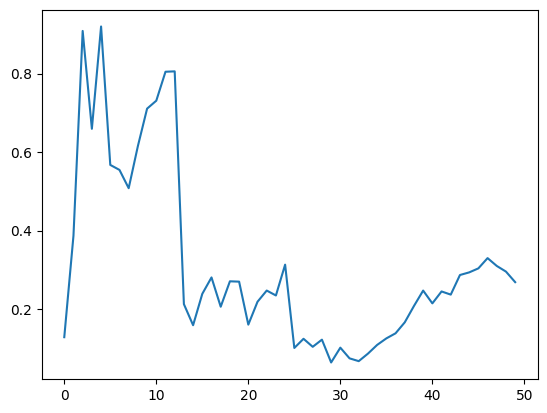

In [11]:
# Creazione di un DataFrame di esempio con due serie temporali
data = pd.DataFrame({'column1': stm_diff,'column2': tsmc_diff})
# Esecuzione del test di Granger
maxlag=50
results = grangercausalitytests(data, maxlag,addconst=True,verbose=False)
# Visualizzazione dei risultati
punto = [ ]
for lag in results.keys():
    #print(f'Lag: {lag}')
    #print(f'Granger causality p-value: {results[lag][0]["ssr_ftest"][1]}')
    #print('-----------------------------------------------------')
    punti=punto.append(results[lag][0]['ssr_ftest'][1])
plt.plot(punto)
print('p-value minimo =', min(punto))
print('lag = ', np.argmin(punto))




p-value minimo = 0.01248339191148407
lag =  94


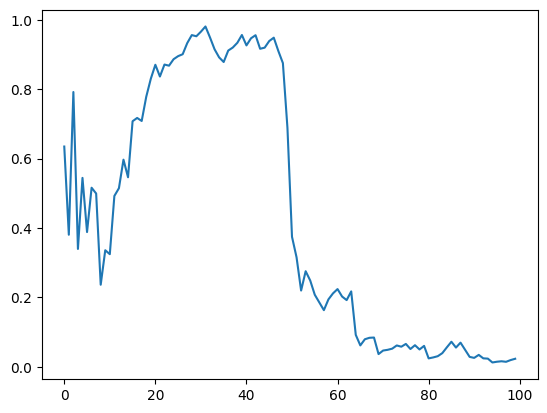

In [13]:
# Creazione di un DataFrame di esempio con due serie temporali
data = pd.DataFrame({'column1': intel_diff,'column2': tsmc_diff})
# Esecuzione del test di Granger
results = grangercausalitytests(data, maxlag=100,addconst=True,verbose=False)
# Visualizzazione dei risultati
punto = [ ]
for lag in results.keys():
    #print(f'Lag: {lag}')
    #print(f'Granger causality p-value: {results[lag][0]["ssr_ftest"][1]}')
    #print('-----------------------------------------------------')
    punti=punto.append(results[lag][0]['ssr_ftest'][1])
plt.plot(punto)
print('p-value minimo =', min(punto))
print('lag = ', np.argmin(punto))


INTEL-STM

p-value minimo = 0.9999999999999999
lag =  5


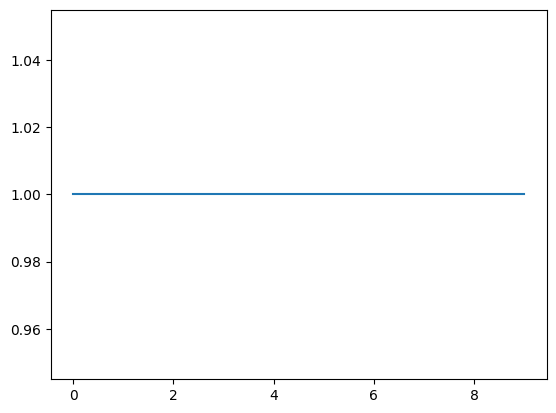

In [14]:
# Creazione di un DataFrame di esempio con due serie temporali
data = pd.DataFrame({'column1': stm_diff,'column2': stm_diff})
# Esecuzione del test di Granger
results = grangercausalitytests(data, maxlag=10,addconst=True,verbose=False)
# Visualizzazione dei risultati
punto = [ ]
for lag in results.keys():
    #print(f'Lag: {lag}')
    #print(f'Granger causality p-value: {results[lag][0]["ssr_ftest"][1]}')
    #print('-----------------------------------------------------')
    punti=punto.append(results[lag][0]['ssr_ftest'][1])
plt.plot(punto)
print('p-value minimo =', min(punto))
print('lag = ', np.argmin(punto))


In [15]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import adfuller, kpss, grangercausalitytests
import warnings
warnings.filterwarnings("ignore")


In [16]:
def splitter(data_df):
    end = round(len(data_df)*.8)
    train_df = data_df[:end]
    test_df = data_df[end:]
    return train_df, test_df

def select_p(train_df):
    aic, bic, fpe, hqic = [], [], [], []
    model = VAR(train_df) 
    p = np.arange(1,60)
    for i in p:
        result = model.fit(i)
        aic.append(result.aic)
        bic.append(result.bic)
        fpe.append(result.fpe)
        hqic.append(result.hqic)
    lags_metrics_df = pd.DataFrame({'AIC': aic, 
                                    'BIC': bic, 
                                    'HQIC': hqic,
                                    'FPE': fpe}, 
                                   index=p)    
    fig, ax = plt.subplots(1, 4, figsize=(15, 3), sharex=True)
    lags_metrics_df.plot(subplots=True, ax=ax, marker='o')
    plt.tight_layout()
    print(lags_metrics_df.idxmin(axis=0))